In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Harris-Stephens Corner Detection

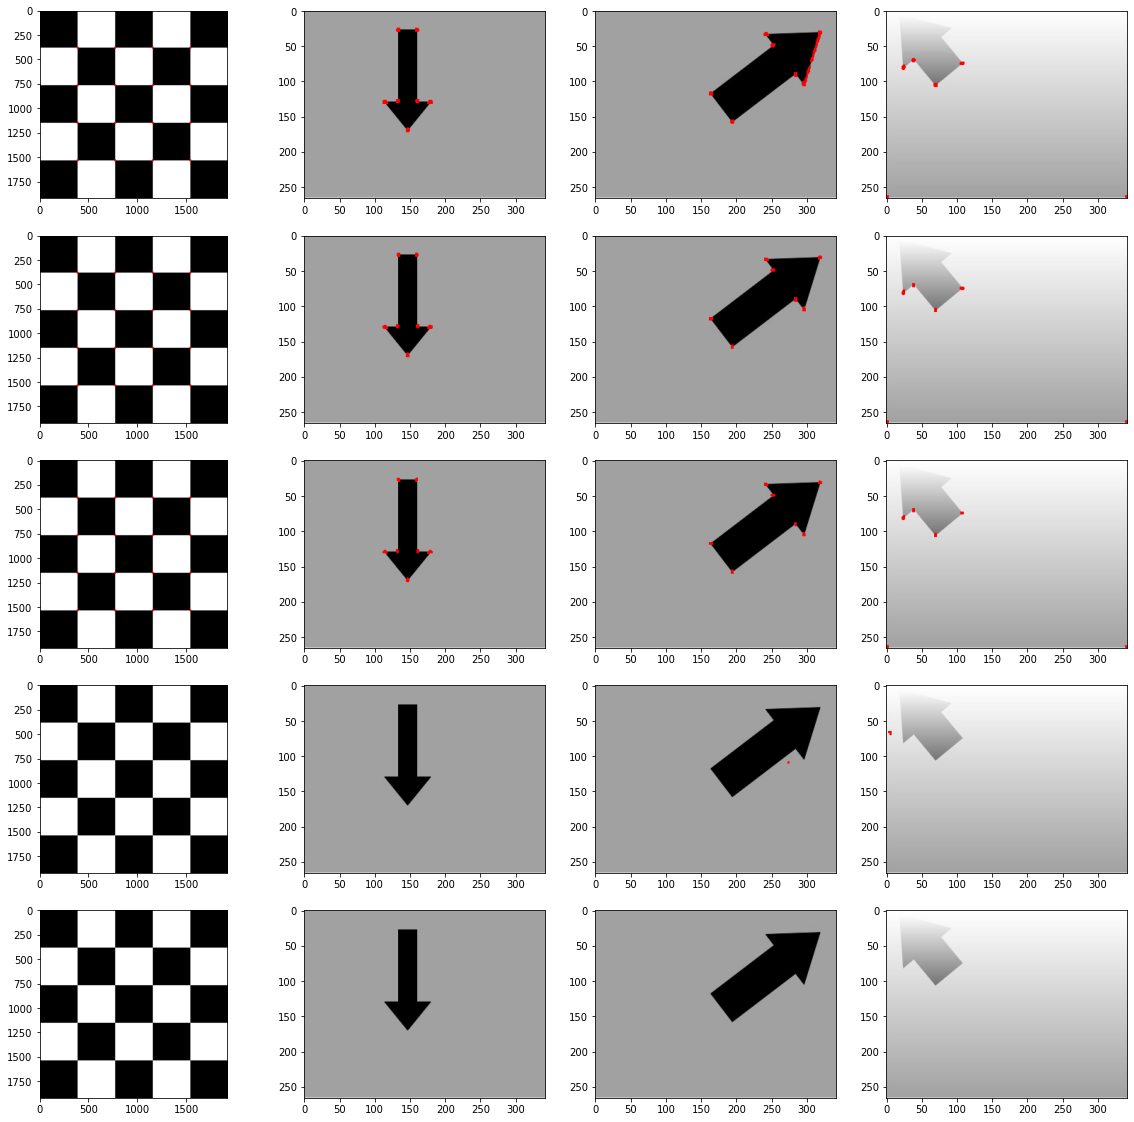

In [179]:
def draw_corners(Im,block ,ksize,k):
    
    corners = cv2.cornerHarris(Im, blockSize=block, ksize=ksize, k=k)
    marked = cv2.cvtColor(Im, cv2.COLOR_GRAY2RGB)
    max_val = 0.01*corners.max()
    scaled_size = Im.shape[0]//200

    corners = cv2.dilate(corners,None)
    ret, dst = cv2.threshold(corners,0.01*corners.max(),255,0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners_refined = cv2.cornerSubPix(Im,np.float32(centroids),(5,5),(-1,-1),criteria)
    
    for i, y in enumerate(corners):
        for j, x in enumerate(y):
            if x > max_val:
                marked = cv2.drawMarker(marked, (j, i), color=(255,0,0), markerType=cv2.MARKER_CROSS, markerSize=scaled_size, thickness=scaled_size)
             
    plt.imshow(marked)

paths = ['chessboard.png', 'arrow_1.jpg', 'arrow_2.jpg', 'arrow_3.jpg',]
k_vals = [0.001, 0.04, 0.1, 0.25, 0.3]

plt.figure(figsize=(20,20))

for i, path in enumerate(paths):
    for j, k in enumerate(k_vals):
        plt.subplot(5, 4, (j*4)+i+1)
        Im = cv2.imread(f'./images/{path}', cv2.IMREAD_GRAYSCALE)
        draw_corners(Im, 3,3,k)

plt.show()

Size of image before pyrDown:  (4032, 3024)
Size of image after pyrDown:  (2016, 1512)
Size of image after pyrDown:  (1008, 756)
Size of image after pyrDown:  (504, 378)


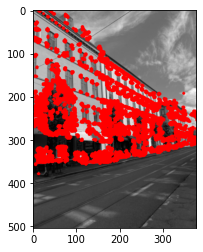

In [214]:

image = cv2.imread(f'./images/street.jpg', cv2.IMREAD_GRAYSCALE)
print("Size of image before pyrDown: ", image.shape)

image = cv2.pyrDown(image)
print("Size of image after pyrDown: ", image.shape)
image = cv2.pyrDown(image)
print("Size of image after pyrDown: ", image.shape)
image = cv2.pyrDown(image)
print("Size of image after pyrDown: ", image.shape)
plt.imshow(image, cmap='gray')
draw_corners(image, 5,3,0.1)

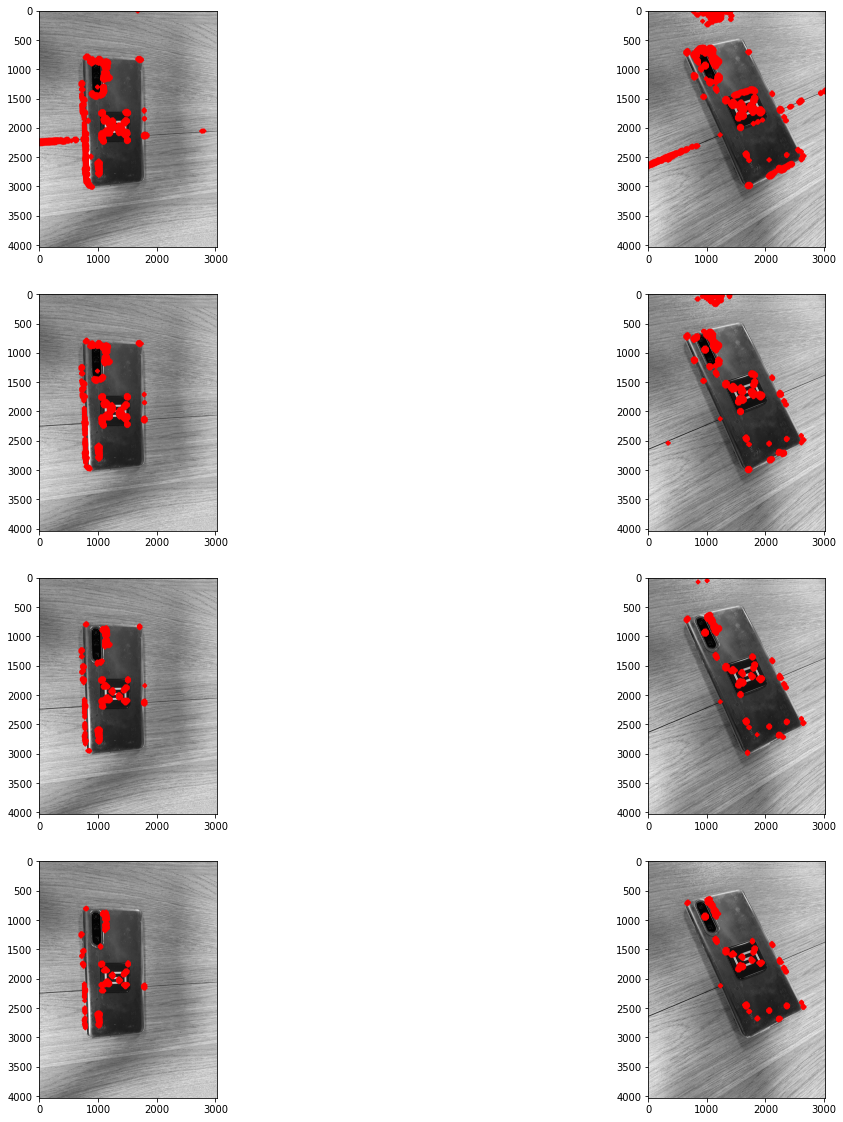

In [136]:
paths = ['corner_phone/IMG_6182.jpg','corner_phone/IMG_6183.jpg']
k_vals = [0.001, 0.04, 0.1, 0.15]

plt.figure(figsize=(20,20))

for i, path in enumerate(paths):
    for j, k in enumerate(k_vals):
        plt.subplot(4, 2, (j*2)+i+1)
        Im = cv2.imread(f'./images/{paths}', cv2.IMREAD_GRAYSCALE)
        draw_corners(Im, 45,31,k)

plt.show()


# SIFT Feature Detection

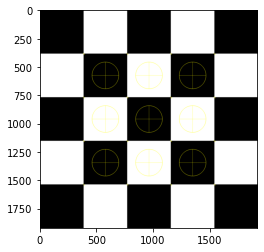

In [ ]:
img = cv2.imread('images/chessboard.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(img, None)

out_img = cv2.drawKeypoints(img, kp, None, (255, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(out_img)

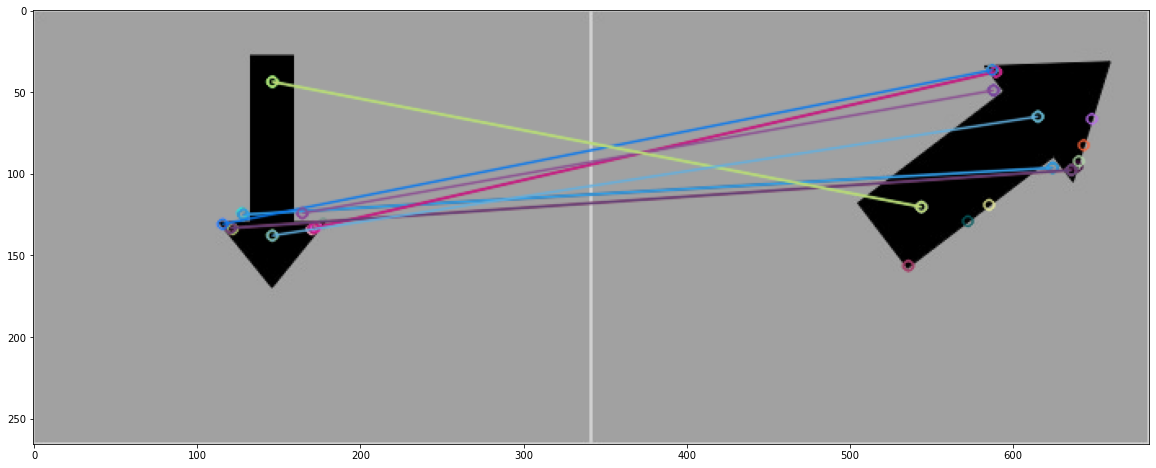

In [ ]:
arrow1 = cv2.imread('images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)
arrow2 = cv2.imread('images/arrow_2.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(arrow1, None)
kp2, des2 = sift.detectAndCompute(arrow2, None)

# initialize Brute force matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)

#sort the matches 
matches = sorted(matches, key= lambda match : match.distance)

matched_img = cv2.drawMatches(arrow1, kp1, arrow2, kp2, matches[:30], None) 

plt.figure(figsize=(20,20))
plt.imshow(matched_img)

In [4]:
# Create SIFT detector object
sift = cv2.xfeatures2d.SIFT_create()
# Define parameters for our Flann Matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks = 100)

def sift_detector(new_image, image_template, template_descriptor):
    # Function that compares input image to template
    # It then returns the number of SIFT matches between them
    image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    # Obtain the descriptors using SIFT
    _, descriptors_1 = sift.detectAndCompute(image, None)

    # Create the Flann Matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtain matches using K-Nearest Neighbor Method
    # the result 'matchs' is the number of similar matches found in both images
    matches = flann.knnMatch(descriptors_1, template_descriptor, k=2)

    # Store good matches using Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 

    return len(good_matches)

cap = cv2.VideoCapture(0)

# Reference image templates
images = [[cv2.imread(f'sift_images/{img}', 0), img] for img in os.listdir('sift_images')]

# Add descriptors to reference images
for img in images:
    _, descriptor = sift.detectAndCompute(img[0], None)
    img.append(descriptor)

# Get webcam images
ret, frame = cap.read()

# Get height and width of webcam frame
height, width = frame.shape[:2]

# Define ROI Box Dimensions
top_left_x = int (width / 3)
top_left_y = int ((height / 2) + (height / 4))
bottom_right_x = int ((width / 3) * 2)
bottom_right_y = int ((height / 2) - (height / 4))

# Our threshold to indicate object deteciton
# We use 10 since the SIFT detector returns little false positves
threshold = 10

while True:
    # Get webcam images
    ret, frame = cap.read()

    # Draw rectangular window for our region of interest   
    cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), 255, 3)

    # Crop window of observation we defined above
    cropped = frame[bottom_right_y:top_left_y , top_left_x:bottom_right_x]

    # Flip frame orientation horizontally
    frame = cv2.flip(frame,1)

    for img in images:
        # Get number of SIFT matches
        matches = sift_detector(cropped, img[0], img[2])

        # # Display status string showing the current no. of matches 
        # cv2.putText(frame,str(matches),(450,450), cv2.FONT_HERSHEY_COMPLEX, 2,(0,255,0),1)

        if matches > threshold:
            cv2.rectangle(frame, (top_left_x,top_left_y), (bottom_right_x,bottom_right_y), (0,255,0), 3)
            cv2.putText(frame,img[1],(50,50), cv2.FONT_HERSHEY_COMPLEX, 2,(0,255,0),1)

    cv2.imshow('Object Detector using SIFT', frame)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()

# Image Stitching with Harris-Stephens corner detection, SIFT and homography estimation using RANSAC

In [4]:
import imageio
import imutils

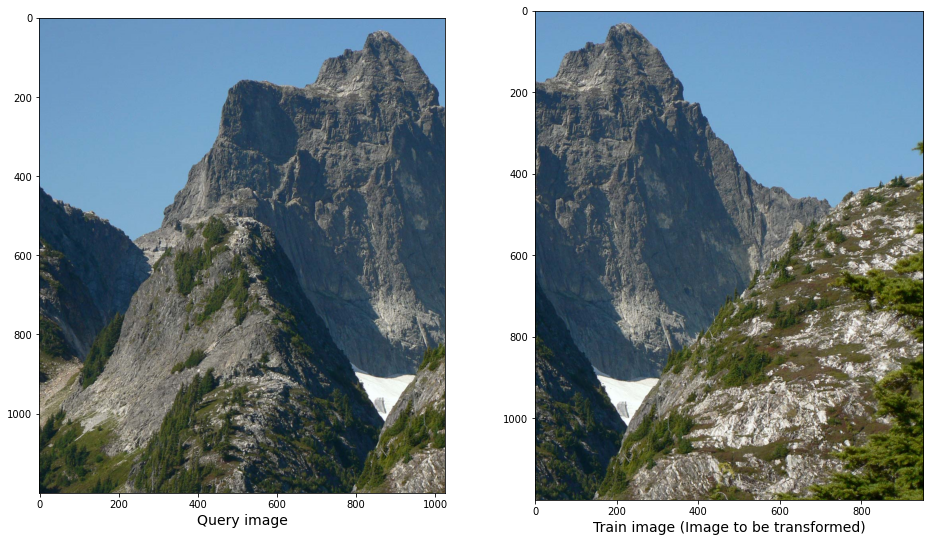

In [132]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = imageio.imread('stitch_images/fjell2.png')

# trainImg = cv2.imread('stitch_images/foto1A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('stitch_images/fjell1.png')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [133]:
# Compute key points and feature descriptors using an specific method
def detectAndDescribe(image):
    descriptor = cv2.xfeatures2d.SIFT_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

# Create and return a Matcher Object
def createMatcher(crossCheck):
    return cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)

def matchKeyPointsBF(featuresA, featuresB):
    bf = createMatcher(crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio):
    bf = createMatcher(crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [134]:
kpsA, featuresA = detectAndDescribe(trainImg_gray)
kpsB, featuresB = detectAndDescribe(queryImg_gray)

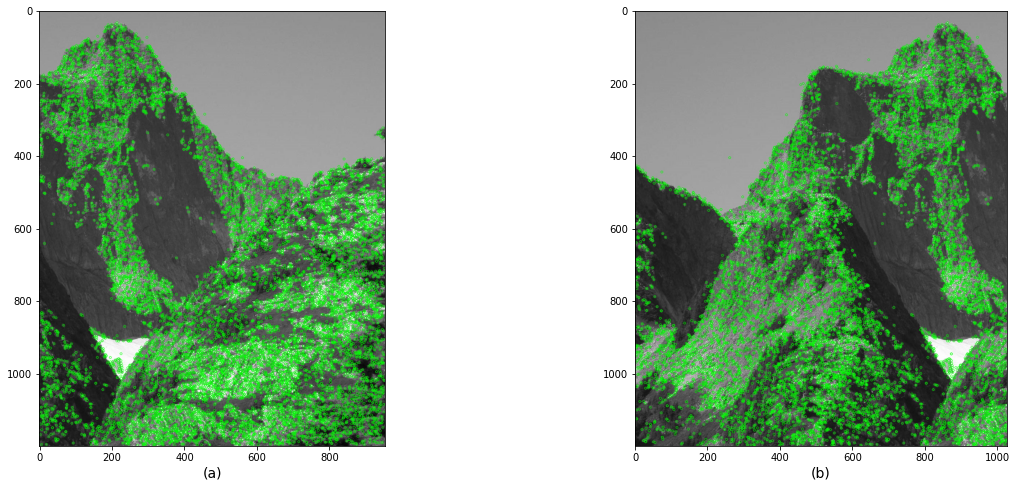

In [135]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: bf feature matcher
Raw matches (Brute force): 5975


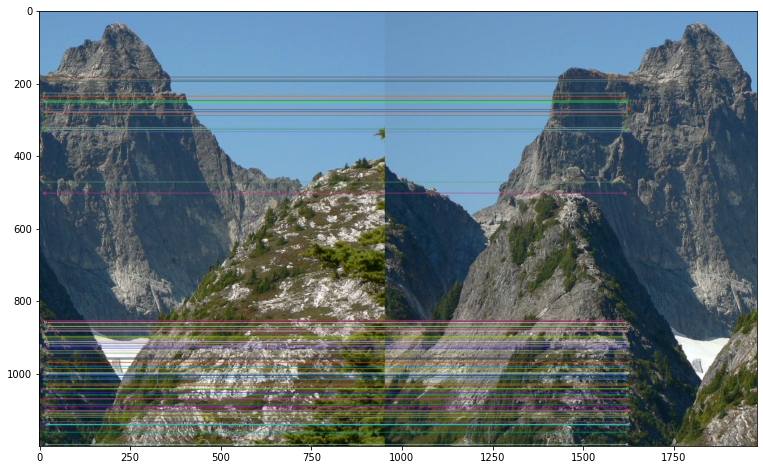

In [136]:
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [137]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [138]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.00000012e+00 -1.07238051e-05  6.47003285e+02]
 [ 5.92673728e-06  9.99985367e-01  2.53952046e-03]
 [ 1.53066380e-08 -1.24581778e-08  1.00000000e+00]]


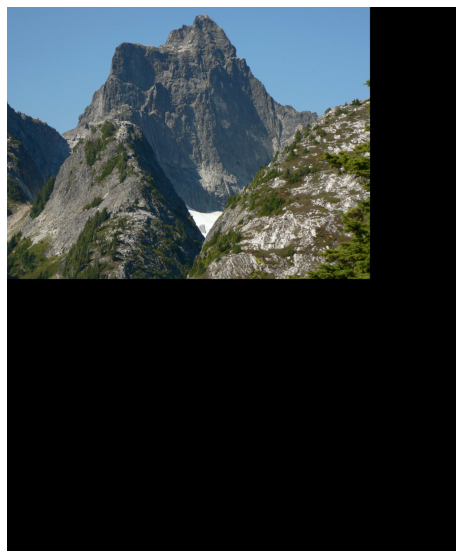

In [139]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

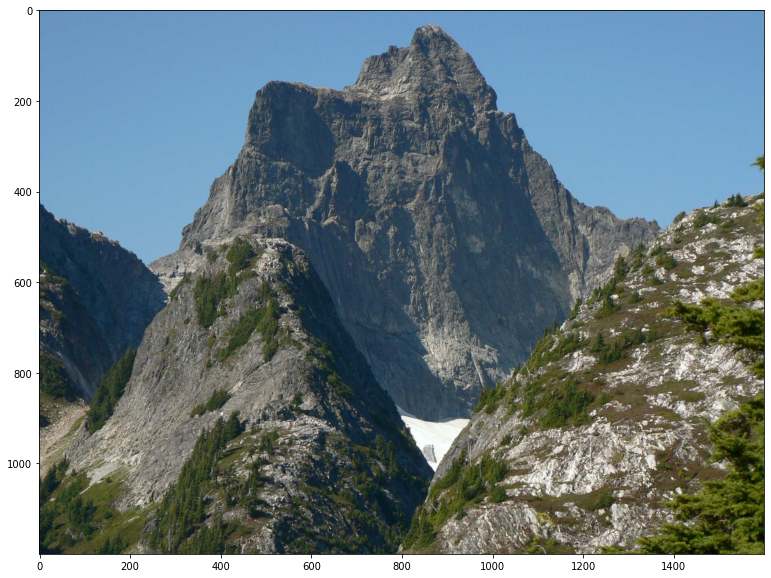

In [140]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)